In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
import gensim
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [5]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macarthur/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macarthur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
files = glob.glob('results_csv/*.csv')

df_hits = pd.DataFrame()

for f in files:
    csv = pd.read_csv(f)
    df_hits = df_hits.append(csv)

In [19]:
lyrics_input = df_hits['Lyrics'].tolist()

In [20]:
def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'


In [21]:
def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'


In [22]:
def preprocess(text):
    stop_words = stopwords.words('english')
    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer()
    return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]

In [25]:
corp = [preprocess(lyrics) for lyrics in lyrics_input]

In [26]:
dictionary = gensim.corpora.Dictionary(corp)
len(dictionary)

5084

In [28]:
bow = [dictionary.doc2bow(line) for line in corp]


In [29]:
def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) for t in range(ntopics) for w,p in model.get_topic_terms(t, topn=1)]
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

In [32]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    # visuzlize the model term topics
    viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=3)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(lyrics_input,bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('{} {}'.format(line, doc_topics))
    return model

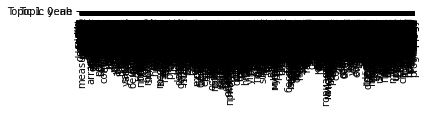

p sendin' 'em?
Women are caught in webs, spin 'em and hock venom
Adrenaline shots of penicillin could not get the illin' to stop
Amoxicillin's just not real enough
The criminal, cop-killin', hip-hop villain
A minimal swap to cop millions of Pac listeners
You're comin' with me, feel it or not
You're gonna fear it like I showed ya the spirit of God lives in us
You hear it a lot, lyrics to shock
Is it a miracle or am I just product of pop fizzin' up?
Fa' shizzle, my wizzle, this is the plot, listen up
You bizzles forgot, Slizzle does not give a fuck

[Chorus: Nate Dogg & Eminem]
'Til the roof comes off, 'til the lights go out
'Til my legs give out, can't shut my mouth
'Til the smoke clears out, am I high? Perhaps
I'ma rip this shit 'til my bones collapse
'Til the roof comes off, 'til the lights go out
Until the roof, until the roof
'Til my legs give out, can't shut my mouth
The roof comes off, the roof comes off
'Til the smoke clears out, am I high? Perhaps
Until my legs, until my legs
I'

In [33]:
test_eta('auto',dictionary,ntopics=2)
